# Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from scipy.stats import truncnorm
import pandas as pd
from tensorflow.keras.losses import MeanSquaredError
import math
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from friberg import *
from utils import *
from NARX import *

%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
    FunctionTransformer

In [2]:
# helper function
log_transformer = FunctionTransformer(np.log10,
                                      inverse_func=lambda x: 10.**x,
                                      validate=True, check_inverse=True)

# Simulate patient time series

We here create a simulated patient time series with the Friberg model, to showcase NARX learning and modeling. 

## draw randomly from friberg population parameters

In [3]:
p0 = np.array([0.316, 195, 2., 270.])    # (gamma, MTT in h, slope, c0 in cells/(l * 10^9))
pop_params = p0
bounds = [(0.05, 0.45), (20, 350), (1., 5),
              (25, 450)]

In [4]:
lower = [x[0] for x in bounds]
upper = [x[1] for x in bounds]
mu, sigma = p0, 0.2 * p0
pat_p = truncnorm.rvs(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma, random_state=0)

In [5]:
# friberg parameters to simulate patient: gamma, MTT in h, slope, c0 in cells/(l * 10^9)
pat_p

array([  0.3222668 , 217.17298364,   2.10676328, 276.05649911])

## generate generic treatment
We simulate 6 rounds of a 21d treatment with the same dose each time. This is how six rounds of a CHOP-21 treatment is simulated in our publication.

In [6]:
therapy = (np.arange(0,6)*21, np.ones(6))    # (days, dosage)

Measurement times are specified to be every 4 days

In [7]:
t_arr = np.arange(0, 6*21)[::4]
t = np.arange(0,t_arr[-1] + 1)

## generate patient time series with friberg model

In [8]:
y_raw = friberg(pat_p, t_arr, therapy) # simulated observations
y_o = friberg(pat_p, t.astype(int), therapy) # friberg time series for 1 day time steps

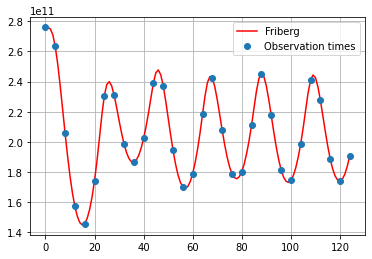

In [9]:
plt.plot(t, y_o, c='r', label='Friberg')
plt.plot(t_arr, y_raw, ls='', marker='o', label='Observation times')
plt.legend()
plt.grid(True)

## add noise and cumulative toxicity
To showcase transfer learning, we add noise and a cumulative toxicity pattern, so our simulated patient is composed of a pattern originating from the Friberg model and an individual pattern. As this is just a demonstration of our NARX modeling, we do not claim this to be a good representation of a real patient.

In [10]:
noise = 0.1
rng = np.random.default_rng(seed=0)
noise_std = y_raw * noise
noise_add = np.array([rng.normal(0, noise_std[j], 1) for j in range(len(y_raw))]).flatten()
y_arr = (y_raw + noise_add)-(1-np.exp(-np.linspace(0,1, t_arr[-1]+1))[t_arr]) * y_raw[0] * 0.5

For comparison, we include NCI thrombocytopenia degrees (TD) in the plot.

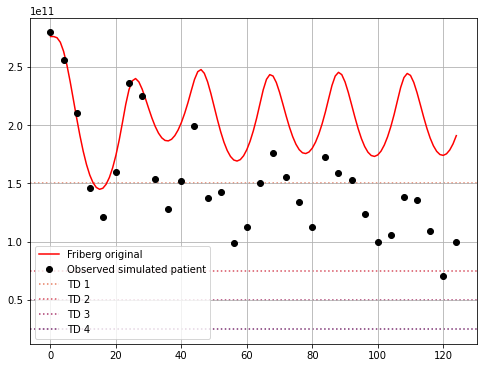

In [11]:
plt.figure(figsize=(8,6))
plt.plot(t, y_o, c='r', label='Friberg original')
plt.plot(t_arr, y_arr, c='k', ls='', marker='o', label='Observed simulated patient')
colors = sns.color_palette('flare', 4)
plt.axhline(1.5*10**11, zorder=1, c=colors[0], label='TD 1', ls=':')
plt.axhline(7.5 * 10**10, zorder=1, c=colors[1], label='TD 2',  ls=':')
plt.axhline(5 * 10**10, zorder=1, c=colors[2], label='TD 3',  ls=':')
plt.axhline(2.5 * 10**10, zorder=1, c=colors[3], label='TD 4',  ls=':')
plt.legend()
plt.grid(True)

## simulated patient dataset
Finally, we create a pandas dataframe to handle the data of the simulated patient easier. We add the cycle number to the observations.

In [12]:
pcycle = np.outer(np.arange(1,7), np.ones((21,1))).flatten()[::4]

In [13]:
df_p = pd.DataFrame(np.array([y_arr/10**9, t_arr, pcycle]).T, columns=['Y', 'TIME', 'CYCLE'])

In [14]:
# final dataset
df_p

,Y,TIME,CYCLE
0,279.527364,0.0,1.0
1,255.490438,4.0,1.0
2,210.514885,8.0,1.0
3,146.082293,12.0,1.0
4,121.289745,16.0,1.0
5,159.942264,20.0,1.0
6,236.319156,24.0,2.0
7,224.924043,28.0,2.0
8,153.462683,32.0,2.0
9,128.070851,36.0,2.0


## define learning scenario
Here, we define the learning scenario, how many cycles are available for learning. We use a dictionary which supplies all necessary information to the NARX model, later.

In [15]:
hp = {'cycle': 4}

We create a dataframe of only the data used for learning.

In [16]:
t = np.arange(0, t_arr[-1] + 1, 1)
# get cycle data
df_p1_c = df_p[df_p['CYCLE'] <= hp['cycle']]
cycle = int(df_p1_c['CYCLE'].max())
t_c = df_p1_c['TIME'].to_numpy().astype(int)
y_arr_c = df_p1_c['Y'].to_numpy() * 10 ** 9

In [17]:
therapies_c = (therapy[0][:cycle], therapy[1][:cycle])

# Friberg calibration
For transfer learning and comparison, we calibrate the Friberg model to the simulated individual data. 

In [18]:
res = minimize(poplog_fit_friberg_mse, p0,
                   args=(pop_params, y_arr_c, t_c, therapies_c),
                   bounds=bounds,
                   method='Nelder-Mead', tol=10 ** -2)

In [19]:
pc = res.x
y_fri = friberg(pc, t.astype(int), therapy)

In [20]:
# calibrated friberg parameters
pc

array([  0.29494076, 200.91384868,   2.18593799, 232.49929285])

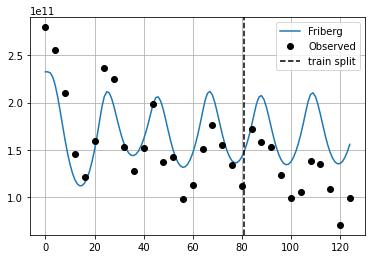

In [21]:
plt.plot(t, y_fri, label='Friberg')
plt.plot(t_arr, y_arr, c='k', ls='', marker='o', label='Observed')
plt.axvline(t_c[-1] +1, c='k', ls='--', label='train split')
plt.legend()
plt.grid(True)

# NARX modeling

We define the dictionary which includes all relevant info and configuration for our NARX model.

In [22]:
hp.update({
    'seed': 0,
    # network configurations
    # configuration for FNN memory
    'xlag': 28,
    'ylag': 21,
    # length of initial steady state, needs to be == max(xlag, ylag)
    'lag': 28,
    # size of hidden layer
    'units': 64, # for GRU:64, for FNN: 4
    'activation': 'sigmoid',
    # activation output layer, should be linear
    'out_act': 'linear',
    'in_bias': True,  # bias term for input
    'out_bias': False, # bias term for output
    'pre-training': True, # with or without transfer learning
    'index': True, # if index patient should be used, only for transfer learning
    'step_mse': True, # if step_mse is used for learning
    # which type of network is created
    'celltype': 'GRU', # change to 'FNN' or 'GRU'
    'es': True, # if exponential smoothing is used for FNN
    # scaling ranges for data
    'scale_range_lower': [-1, -0.5],
    'scale_range_upper': [0.5, 1.5],
    # sclaling lower and upper
    '4degree': 25 * 10 ** 9,
    'normal': 300 * 10 ** 9,
    # parameters for regularization and smoothing
    'k': 2,
    'c': 10 ** -2,
    's': 1.,
    'alpha': 10 ** -3,
    'delta': 0.007,
    'lp': 0.0001,
    'in_dr': 0., # for no ptr: 0.05,
    're_dr': 0., # for no ptr: 0.1,
    'out_dr': 0.,
    'ker_l2': 0.,
    're_l2': 0.,
    'out_l2': 0.01,
    's_train': 0.1,
    'stddev_ft': 0.2,
    'stddev': 0.,
    # fit configuration for early stopping
    'patience': 250,
    'max_epochs': 10200,
    'min_delta_fri': 10 ** -4,
    'min_delta_ft': 10 ** -5, 
    'min_delta_ptr': 10 ** -4,
    'av_epochs': 20,
    # learning rates
    'lr': 0.01,
    'lr_ft': 0.001,
      })

## load index patient weights
The index patient is also a simulated patient, which represents the population average parameters of the friberg model. Beginning here for transfer learning speeds up the training process immensely.

In [23]:
index_path = os.path.join('.', f'index_weights_{hp["celltype"]}.h5')

In [24]:
hp['index_path']= index_path

## prepare data for NARX

In [25]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tf.keras.utils.set_random_seed(
    hp['seed']
)

In [26]:
xlag = hp['xlag']
ylag = hp['ylag']

### scale data

In [27]:
if hp['celltype']=='FNN':
    lower = hp['scale_range_lower'][0]
    upper = hp['scale_range_upper'][1]
else:
    lower = hp['scale_range_lower'][1]
    upper = hp['scale_range_upper'][0]

scalery_gen = MinMaxScaler(feature_range=(lower, upper))
# scale like neutropenia degree
scalery_gen.fit(log_transformer.transform(
    np.array([hp['4degree'], hp['normal']]).reshape(-1, 1)))

MinMaxScaler(feature_range=(-0.5, 0.5))

In [28]:
y_sc_c = scalery_gen.transform(
    log_transformer.transform(y_arr_c.reshape(-1, 1))).flatten()

In [29]:
# inlcude stable state for warmup
stst = y_sc_c[0]
if np.isfinite(y_sc_c[0]) == False:
    if hp['pre-training']:
        stst = scalery_gen.transform(
            log_transformer.transform(np.array(
                pc[-1]).reshape(-1, 1))).flatten()
    else:
        stst = np.nanmean(y_sc_c)

### generate Transfer learning data of different treatment scenarios

In [30]:
if hp['pre-training']:
    sc_df = pd.read_csv('therapies_all.csv', index_col=0)
    t_sc = np.arange(0,300) # scenarios have a length of 300 days
    y_frtrain = friberg(pc, t_sc, therapy)
    X = np.zeros(len(t))
    X[therapy[0]] = therapy[1]

    y_frsc = [y_frtrain]
    
    # training scenarios
    for i in range(7):
        therapy_sc = (sc_df[f'therapy_days_set{i}'].astype(int).to_numpy(),
            sc_df[f'dosages_set{i}'].to_numpy())
        y_sc = friberg(pc, t_sc, therapy_sc)
        y_frsc.append(y_sc)
        
    y_frsc = np.array(y_frsc)
    X_frsc = np.zeros((8, 300))
    X_frsc[0, therapy[0]] = therapy[1]
    for i in range(7):
        day = sc_df[f'therapy_days_set{i}'].astype(int).to_numpy(),
        dose = sc_df[f'dosages_set{i}'].to_numpy()
        X_frsc[i + 1, day] = dose

else:
    X = np.zeros(len(t))
    X[therapy[0]] = therapy[1]

In [31]:
# pad data for initial stable state for warm up 
X_add = np.concatenate([np.zeros((28)), X], 0)

# transform data to log
y = scalery_gen.transform(
    log_transformer.transform(y_arr.reshape(-1, 1))).flatten()
ylog = log_transformer.transform(y_arr.reshape(-1, 1)).flatten()
y_pad = np.nan * np.ones(len(X))
y_pad[t_arr] = y
y_padlog = np.nan * np.ones(len(X))
y_padlog[t_arr] = ylog

In [32]:
# test part of individual ts
l = t_c[-1] + 1
y_add = np.concatenate([stst * np.ones(28), y_pad], 0)
sparse_all = np.nan * np.ones(len(X))
sparse_all[t_arr] = 1.
y_test = y_pad[l:]
y_testlog = y_padlog[l:]

In [33]:
# train part of individual ts
y_train = y_add[:l + 28]
X_train = X_add[:l + 28]

In [34]:
# train/test split of friberg scenarios if pre-training is used
if hp['pre-training']:
    X_frtrain = X_frsc[:6]
    X_frtest = X_frsc[6:]

    y_frtest = y_frsc[6:]
    y_frtrain = y_frsc[:6]

    # concat steady state
    X_frtest = np.concatenate([np.zeros((2,28)), X_frtest], 1)
    X_frtrain = np.concatenate([np.zeros((6, 28)), X_frtrain], 1)
    shape_train = y_frtrain.shape
    shape_test = y_frtest.shape
    y_frtrain = np.concatenate(
        [np.ones((6, hp['lag'])) * stst, scalery_gen.transform(
        log_transformer.transform(
        y_frtrain.reshape(-1,1))).reshape(shape_train)], 1)
    y_frtest = np.concatenate(
        [np.ones((2,hp['lag'])) * stst, scalery_gen.transform(
            log_transformer.transform(
        y_frtest.reshape(-1,1))).reshape(shape_test)],1)

### shape data to work with NARX architecture

In [35]:
# shape ts to work with ARX architecture
feat_gru = np.vstack([X_train, y_train]).T
feat_gru[xlag:, 1] = np.zeros(len(y_train) - xlag) * np.NaN
shape = feat_gru.shape
feat_gru = feat_gru.reshape(1, shape[0], shape[1])
target_gru = y_train[hp['lag']:].reshape(1, shape[0] - xlag,
                                          1)
test_gru = np.vstack([X_add, y_add]).T
test_gru[xlag:, 1] = np.zeros(len(y_add) - xlag) * np.NaN
shape = test_gru.shape
test_gru = test_gru.reshape(1, shape[0], shape[1])

if hp['pre-training']:
    feat_fr = np.dstack([X_frtrain, y_frtrain])
    feat_fr[:,xlag:, 1] = np.zeros(len(y_frtrain[0]) - xlag) * np.NaN
    target_fr = y_frtrain[:,hp['lag']:]
    val_fr = np.dstack([X_frtest, y_frtest])
    val_fr[:,xlag:, 1] = np.zeros(len(y_frtest[0]) - xlag) * np.NaN
    target_val_fr = y_frtest[:,hp['lag']:]
else:
    feat_fr  = 0.
    target_fr = 0.
    val_fr = 0.
    target_val_fr = 0.

# FNN needs differently shaped features
if hp['celltype'] == 'FNN':
    feat_gru_lag = np.zeros(
            (1, len(X_train) - hp['xlag'] + 1, hp['xlag'] + hp['ylag']))
    for i in range(len(X_train) - hp['xlag'], -1, -1):
        feat_gru_lag[:, i, :hp['ylag']] = feat_gru[:, i:i + hp['ylag'],
                                           1]
        feat_gru_lag[:, i, hp['ylag']:] = feat_gru[:, i:i + hp['xlag'],0]

    if hp['pre-training']:
    # TODO
        feat_fr_lag = np.zeros(
            (X_frtrain.shape[0], X_frtrain.shape[1] - hp['xlag'] + 1,
             hp['xlag'] + hp[
                'ylag']))
        for i in range(X_frtrain.shape[1] - hp['xlag'], -1, -1):
            feat_fr_lag[:, i, :hp['ylag']] = feat_fr[:, i:i + hp['ylag'],1]
            feat_fr_lag[:, i, hp['ylag']:] = feat_fr[:, i:i + hp['xlag'],0]
        val_fr_lag = np.zeros(
            (X_frtest.shape[0], X_frtest.shape[1] - hp['xlag'] + 1,
             hp['xlag'] + hp[
                'ylag']))
        # what about different lags?! if ylag is bigger, then rebuild
        for i in range(X_frtest.shape[1] - hp['xlag'], -1, -1):
            val_fr_lag[:, i, :hp['ylag']] = val_fr[:, i:i + hp['ylag'], 1]
            val_fr_lag[:, i, hp['ylag']:] = val_fr[:, i:i + hp['xlag'], 0]
        feat_fr = feat_fr_lag
        val_fr = val_fr_lag

    test_gru_lag = np.zeros(
        (1, len(X_add) - hp['xlag'] + 1, hp['xlag'] + hp['ylag']))
    for i in range(len(X_add) - hp['xlag'], -1, -1):
        test_gru_lag[:, i, :hp['ylag']] = test_gru[:, i:i + hp['ylag'],
                                           1]
        test_gru_lag[:, i, hp['ylag']:] = test_gru[:, i:i + hp['xlag'],0]
    feat_gru = feat_gru_lag
    test_gru = test_gru_lag

## learning 

### error function

In [36]:
smsem = Step_MSE_missing(s=hp['s'])

In [37]:
def err_func():
    if hp['step_mse']:
        return Step_MSE_missing(s=hp['s_train'])
    else:
        return MSE_missing()

In [38]:
l = t_c[-1] + 1
# clear session for model recreation
tf.keras.backend.clear_session()

### build model

reset some dictionary values for pre-training

In [39]:
# first set dropout to zero if needed:
hpx = hp.copy()
hpx['in_dr'] = 0.
hpx['re_dr'] = 0.
if hp['celltype'] == 'FNN':
    hpx['delta'] = 0.005
hpx['stddev'] = hp['stddev_ft']

get celltype

In [40]:
if hp['celltype'] == 'GRU':
    cell = tf.keras.layers.GRUCell
    model = buildrnn(cell=cell, hp=hp)
    
elif hp['celltype'] == 'FNN':
    model = buildNARX(hp=hp)
else:
    raise ValueError

### Transfer learning

In [41]:
if hp['pre-training']:
    # recompile to MSE, stronger lr etc
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp['lr'],
        decay_steps=1800,
        decay_rate=0.8)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    loss_fn = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss_fn)

    # call on some data to initialize weights, 
    # needs to have the same last shape as training data
    if hp['index']:
        if hp['celltype'] == 'GRU':
            yt = model(np.ones((6, hp['lag'] + 1, 2)))
        elif hp['celltype'] == 'FNN':
            yt = model(feat_gru)
        model.load_weights(hp['index_path'])

    callbacks = tf.keras.callbacks.CallbackList(
        [tf.keras.callbacks.History(),
         EarlyStoppAveraged(monitor='val_loss', av_epochs=hp['av_epochs'],
                                          restore_best_weights=True,
                                          patience=hp['patience'],
                            min_delta=hp['min_delta_fri'])])
    callbacks.set_model(model)

    hist_pre = model.fit(x=feat_fr, y=target_fr,
                              validation_data=(val_fr, target_val_fr),
                             batch_size=None,
                              epochs=hp['max_epochs'], verbose=0,
                              callbacks=callbacks)
    
    model.stop_training = False
    fri_weights = model.get_weights()

    # model with GN
    if hp['celltype'] == 'GRU':
        model = buildrnn(cell=cell, hp=hpx)
    if hp['celltype'] == 'FNN':
        model = buildNARX(hp=hpx)

    # call to initialize weigths again
    if hp['celltype'] == 'GRU':
        yt = model(np.ones((1, hp['lag'] + 1, 2)))
    elif hp['celltype'] == 'FNN':
        yt = model(feat_gru)

    model.set_weights(fri_weights)
    for layer in model.layers[:-1]:
        layer.trainable = False

    # opt params
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp['lr_ft'],
        decay_steps=1800,
        decay_rate=0.8)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # combined loss with smoothing needs to run eagerly
    tf.config.run_functions_eagerly(True)
    loss_fn = tf.function(smse_smoothing(k=int(hpx['k']), c=hpx['c'],
                             s=hpx['s_train']))
    model.compile(optimizer=optimizer, loss=loss_fn)

    # set friberg weights
    model.set_weights(fri_weights)

    callbacks = tf.keras.callbacks.CallbackList(
        [tf.keras.callbacks.History(),
         EarlyStoppAveraged(monitor='loss', av_epochs=hp['av_epochs'],
                                          restore_best_weights=True,
                                          patience=hp['patience'],
                            min_delta=hp['min_delta_ptr'])])
    callbacks.set_model(model)
    hist_pre2 = model.fit(x=feat_gru, y=target_gru,
                         epochs=hp['max_epochs'], verbose=0,
                         callbacks=callbacks)
    model.stop_training = False
    for layer in model.layers[:-1]:
        layer.trainable = True
    ptr_weights = model.get_weights()

    
    # for regularizaton functions to work, do not run eagerly
    tf.config.run_functions_eagerly(False)
    if hp['celltype'] == 'GRU':
        model = buildrnn(cell=cell, hp=hpx)
    if hp['celltype'] == 'FNN':
        model = buildNARX(hp=hpx)

    # opt params
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp['lr_ft'],
        decay_steps=1800,
        decay_rate=0.8)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    loss_fn = Combined_loss([err_func(),
                     smoothing(k=int(hpx['k']), c=hpx['c'])])
    model.compile(optimizer=optimizer, loss=loss_fn)

    # call to initialize weigths again
    if hp['celltype'] == 'GRU':
        yt = model(np.ones((1, hp['lag'] + 1, 2)))
    elif hp['celltype'] == 'FNN':
        yt = model(feat_gru)
        
    model.set_weights(ptr_weights)

    callbacks = tf.keras.callbacks.CallbackList(
        [tf.keras.callbacks.History(),
         EarlyStoppAveraged(monitor='loss', av_epochs=hp['av_epochs'],
                                          restore_best_weights=True,
                                          patience=hp['patience'],
                            min_delta=hp['min_delta_ft'])])
    callbacks.set_model(model)

    hist = model.fit(x=feat_gru, y=target_gru,
                          batch_size=len(target_gru),
                          epochs=hp['max_epochs'], verbose=0,
                          callbacks=callbacks)

/home/mzech/anaconda3/envs/NARX/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### if no Transfer learning is used

In [42]:
if not hp['pre-training']:
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp['lr'],
        decay_steps=1800,
        decay_rate=0.8)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    loss_fn = Combined_loss([err_func(),
                             smoothing(k=int(hp['k']), c=hp['c'])])
    model.compile(optimizer=optimizer, loss=loss_fn)
    callbacks = tf.keras.callbacks.CallbackList(
        [tf.keras.callbacks.History(),
         EarlyStoppAveraged(monitor='loss', av_epochs=hp['av_epochs'],
                                          restore_best_weights=True,
                                          patience=hp['patience'],
                            min_delta=10**-4)])
    callbacks.set_model(model)
    
    #initialize weights
    if hp['celltype'] == 'GRU':
        yt = model(np.ones((1, hp['lag'] + 1, 2)))
    elif hp['celltype'] == 'FNN':
        yt = model(feat_gru)
    
    # training
    hist_ptr = model.fit(x=feat_gru, y=target_gru,
                           batch_size=len(target_gru),
                           epochs=hp['max_epochs'], verbose=0,
                           callbacks=callbacks)

    ptr_weights = model.get_weights()


    # now model without dropout, but with GN
    if hp['celltype'] == 'GRU':
        model = buildrnn(cell=cell, hp=hpx)
    if hp['celltype'] == 'FNN':
        model = buildNARX(hp=hpx)

    # opt params
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp['lr_ft'],
        decay_steps=1800,
        decay_rate=0.8)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    # loss should be MSE_missing
    loss_fn = Combined_loss([err_func(),
                             smoothing(k=int(hp['k']), c=hp['c'])])
    model.compile(optimizer=optimizer, loss=loss_fn)
    
    # call for initialization
    if hp['celltype'] == 'GRU':
        yt = model(np.ones((1, hp['lag'] + 1, 2)))
    elif hp['celltype'] == 'FNN':
        yt = model(feat_gru)

    model.set_weights(ptr_weights)
    model.stop_training = False

    callbacks = tf.keras.callbacks.CallbackList(
        [tf.keras.callbacks.History(),
         EarlyStoppAveraged(monitor='loss',
                            av_epochs=hp['av_epochs'],
                            restore_best_weights=True,
                            patience=hp['patience'], min_delta=10**-5)])
    callbacks.set_model(model)

    hist = model.fit(x=feat_gru, y=target_gru,
                     batch_size=len(target_gru),
                     epochs=hp['max_epochs'], verbose=0,
                     callbacks=callbacks)

# Comparison

## get NARX model prediction and scale back

In [43]:
yhat = model(test_gru).numpy().flatten()

In [44]:
# scale back to original
ynoc = log_transformer.inverse_transform(
    scalery_gen.inverse_transform(yhat.reshape(-1, 1))).flatten()

In [45]:
# log scales for metric
ylog = scalery_gen.inverse_transform(yhat.reshape(-1, 1)).flatten()

In [46]:
# check if full TS was fitted
if hp['cycle'] >= df_p['CYCLE'].max():
    # full time series fit, set whole time series for evaluation
    l = 0
    y_arrlog = log_transformer.transform(y_arr.reshape(-1,
                                                       1)).flatten()
    y_testlog = np.nan * np.ones(len(yhat))
    y_testlog[t_arr] = y_arrlog

## get friberg fit and scale

In [47]:
y_fri_log = log_transformer.transform(
y_fri.reshape(-1, 1)).flatten()

y_sc = scalery_gen.transform(log_transformer.transform(
y_arr.reshape(-1,1))).flatten()

y_fri_sc = scalery_gen.transform(log_transformer.transform(
y_fri.reshape(-1,1))).flatten()

## get metrics

In [48]:
smsem = Step_MSE_missing(s=hp['s'])

In [49]:
# NARX model metric
smse_narx = smsem(y_pred=ylog[l:],
                        y_true=y_testlog).numpy()

In [50]:
# friberg metric
smse_fri = smsem(y_pred=y_fri_log[l:],
             y_true=y_testlog).numpy()

In [51]:
smse_narx, smse_fri

(0.013604221, 0.038475465)

## Comparison plot

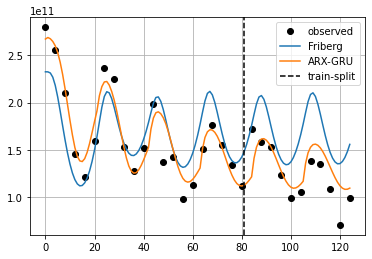

In [52]:
plt.plot(t_arr, y_arr, ls='', marker='o', c='k', label='observed')
plt.plot(t, y_fri, ls='-', label='Friberg')
plt.plot(t, ynoc, label='ARX-GRU')
plt.axvline(l, c='k', ls='--', label='train-split')
plt.grid(True)
plt.legend()